In [112]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [113]:
y=pd.read_excel('e.xlsx')

In [114]:
y['date'] = pd.to_datetime(y['date'])

# 'DateTime' sütununu indeks olarak ayarla
y.set_index('date', inplace=True)

In [115]:
# Hareketli ortalama hesaplama
y['minTwhPerYear'] = y['minTwhPerYear'].rolling(window=3).mean()


In [116]:
# Düzeltme yapma
y['minTwhPerYear'] = y['minTwhPerYear'].ewm(span=3, adjust=False).mean()


In [117]:
y

,minTwhPerYear
date,
2017-02-10,NaN
2017-02-11,NaN
2017-02-12,3.282074
2017-02-13,3.234433
2017-02-14,3.182918
...,...
2024-04-12,95.818178
2024-04-13,96.535764
2024-04-14,97.094919


In [118]:
# Düzeltme yapma
y['minTwhPerYear']  = y['minTwhPerYear'] .ewm(span=3, adjust=False).mean()


In [119]:
Q1 = y['minTwhPerYear'].quantile(0.25)
Q3 = y['minTwhPerYear'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = y[(y['minTwhPerYear'] >= lower_bound) & (y['minTwhPerYear'] <= upper_bound)]


In [120]:
from scipy.stats.mstats import winsorize
y['minTwhPerYear']  = winsorize(y['minTwhPerYear'] , limits=[0.05, 0.05])


In [121]:
import pandas as pd
import numpy as np
from scipy import stats

# Veriyi yükleme


# Gürültüyü azaltma: Ortalama ile doldurma veya lineer interpolasyon gibi yöntemler kullanılabilir
y['minTwhPerYear'] = y['minTwhPerYear'] .fillna(y['minTwhPerYear'] .mean())
# df['degisken'] = df['degisken'].interpolate(method='linear')

# Aşırı yüksek değerleri düzeltme: Z-skorunu hesaplayarak aşırı değerleri belirleme
z_scores = np.abs(stats.zscore(y['minTwhPerYear'] ))
threshold = 3
outlier_indices = np.where(z_scores > threshold)[0]
y['minTwhPerYear'] .iloc[outlier_indices] = np.nan  # Aşırı değerleri NaN olarak işaretleme

# NaN değerleri ortalama veya medyan ile doldurma
y['minTwhPerYear']  = y['minTwhPerYear'] .fillna(y['minTwhPerYear'] .mean())
# df['degisken'] = df['degisken'].fillna(df['degisken'].median())

# İşlenmiş veriyi kullanarak ARIMA modeli eğitimi ve tahmini yapma
# Buraya ARIMA modelini eğitmek ve tahmin yapmak için gerekli kodu ekleyebilirsiniz

y = y.iloc[2:]

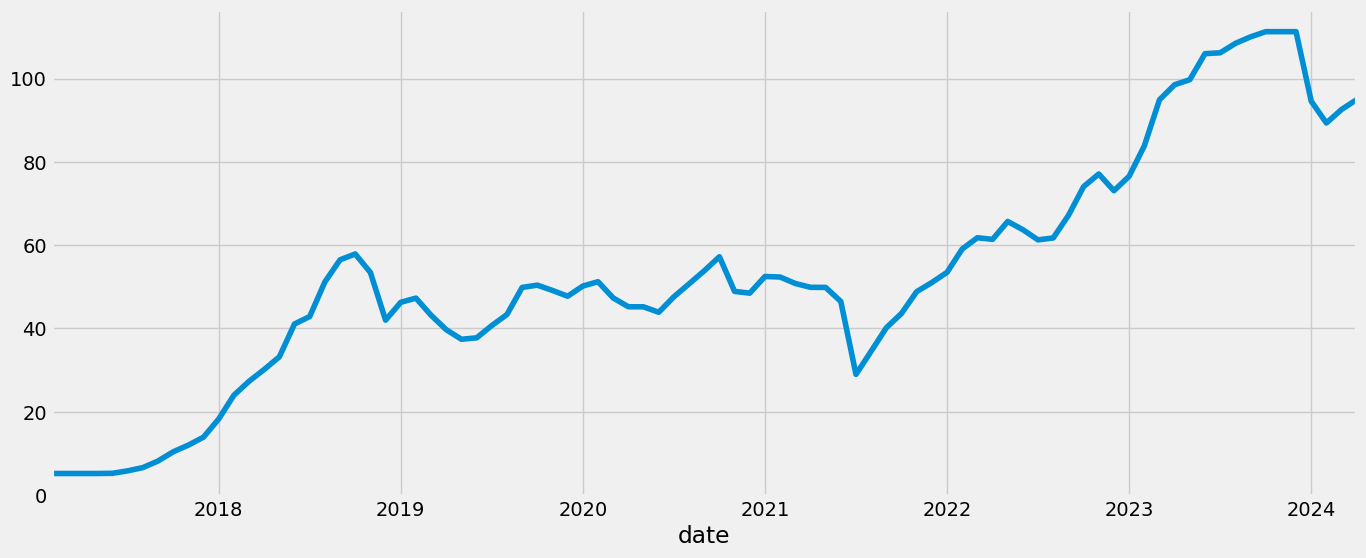

In [122]:


# 'DateTime' sütununu indeks olarak ayarla


minTwhPerYear_monthly_mean = y['minTwhPerYear'].resample('MS').mean()
y = y.fillna(y.bfill())
minTwhPerYear_monthly_mean = minTwhPerYear_monthly_mean.fillna(minTwhPerYear_monthly_mean.bfill())
minTwhPerYear_monthly_mean.plot(figsize=(15, 6))
plt.show()


In [123]:
minTwhPerYear_monthly_mean

date
2017-02-01      5.131475
2017-03-01      5.131475
2017-04-01      5.131475
2017-05-01      5.131475
2017-06-01      5.177489
                 ...    
2023-12-01    111.247450
2024-01-01     94.560955
2024-02-01     89.311799
2024-03-01     92.561764
2024-04-01     94.939851
Freq: MS, Name: minTwhPerYear, Length: 87, dtype: float64

In [124]:
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [125]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(minTwhPerYear_monthly_mean,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:950.6520993723411
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:771.2841999391391
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:676.8005539314956
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:546.2834649461485
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:665.0890068184108
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:637.4154834403083
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:554.1800919849317
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:542.9267600651607
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:832.0398760132153
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:670.8278603873619
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:584.2943782086261
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:475.82147972847395
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:587.6683039005096
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:552.0880375873212
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:493.2957615823405
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:476.2932821748035
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:505.5846720585749
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:442.48298415615704
ARIMA(0,

In [126]:
mod = sm.tsa.statespace.SARIMAX(minTwhPerYear_monthly_mean,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2339      0.575     -0.407      0.684      -1.361       0.893
ma.L1          0.5061      0.587      0.862      0.388      -0.644       1.656
ma.S.L12      -1.0871      0.917     -1.185      0.236      -2.885       0.710
sigma2        17.7492     19.695      0.901      0.367     -20.851      56.350


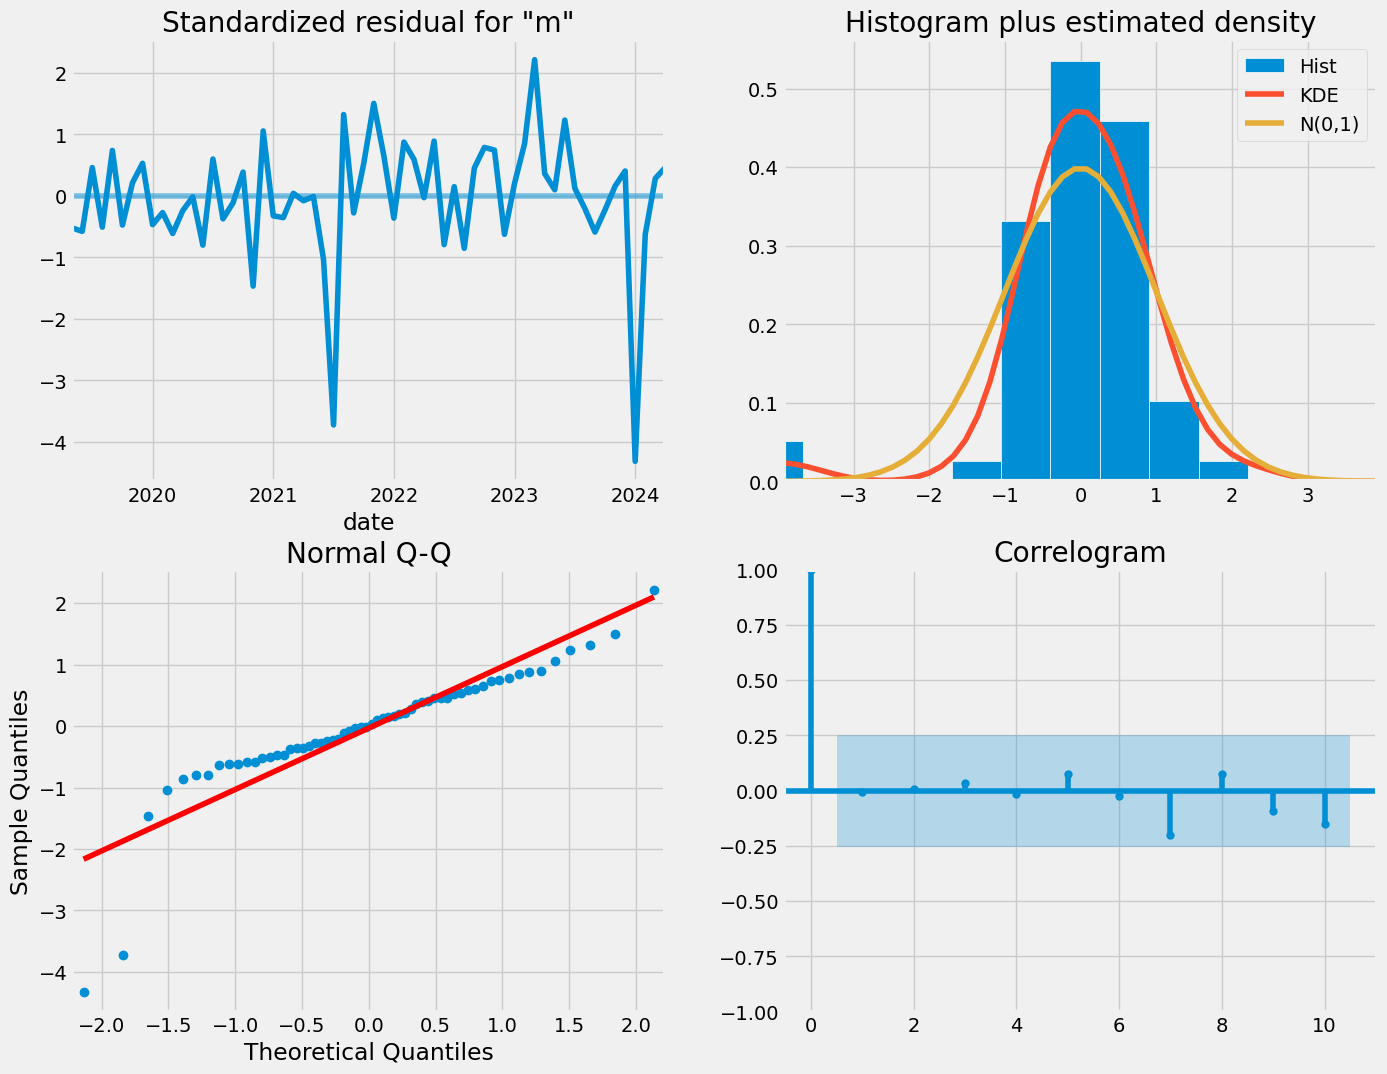

In [127]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [128]:
pred = results.get_prediction(start='2023-02-01', dynamic=False)

pred_ci = pred.conf_int()


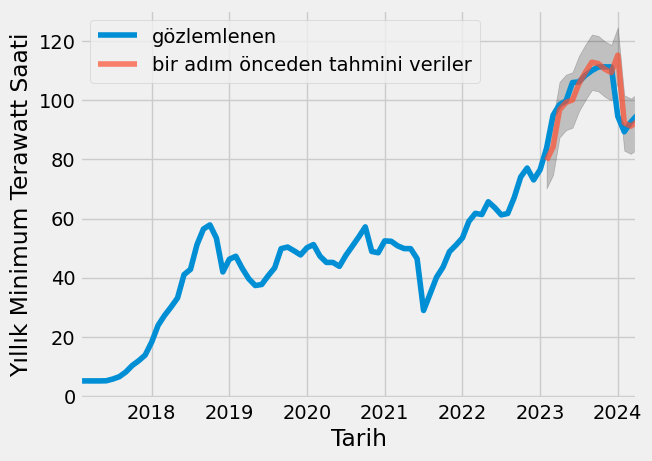

In [131]:
ax = minTwhPerYear_monthly_mean['2017':].plot(label='gözlemlenen')
pred.predicted_mean.plot(ax=ax, label='bir adım önceden tahmini veriler', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Tarih')
ax.set_ylabel('Yıllık Minimum Terawatt Saati')
plt.legend()

plt.show()

In [80]:
 minTwhPerYear_monthly_mean_forecasted = pred.predicted_mean
 minTwhPerYear_monthly_mean_truth = minTwhPerYear_monthly_mean['2023-02-01':]

# Compute the mean square error
mse = (( minTwhPerYear_monthly_mean_forecasted -  minTwhPerYear_monthly_mean_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 41.74


In [81]:

pred = results.get_prediction(start=pd.to_datetime('2023-02-01'), dynamic=False)
pred_ci = pred.conf_int()

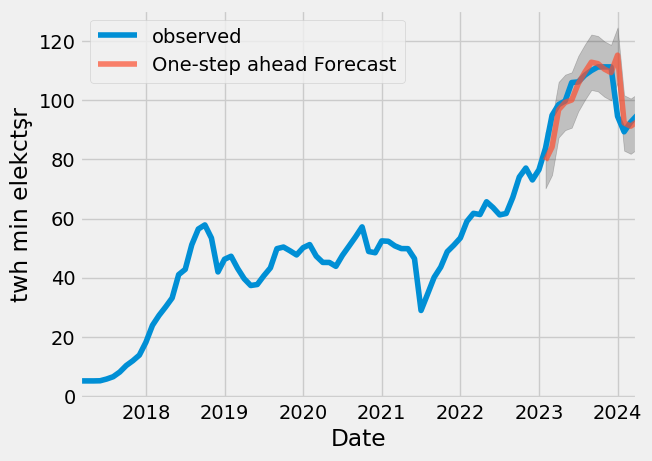

In [82]:
ax = minTwhPerYear_monthly_mean['2017-02-10':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('twh min elekctşr')
plt.legend()

plt.show()

In [83]:
minTwhPerYear_monthly_mean_forecasted = pred.predicted_mean
minTwhPerYear_monthly_mean_truth = minTwhPerYear_monthly_mean['2023-02-01':]

# Compute the mean square error
mse = ((minTwhPerYear_monthly_mean_forecasted - minTwhPerYear_monthly_mean_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 41.74


In [133]:
from sklearn.metrics import r2_score
minTwhPerYear_monthly_mean_forecasted = pred.predicted_mean
minTwhPerYear_monthly_mean_truth = minTwhPerYear_monthly_mean['2023-02-01':]

# Gerçek değerler

# R-kare hesaplama
r2 = r2_score(minTwhPerYear_monthly_mean_truth, minTwhPerYear_monthly_mean_forecasted)

print("R-kare değeri:", r2)
"R-kare (R-squared), "

R-kare değeri: 0.44562811313091577


'R-kare (R-squared), '

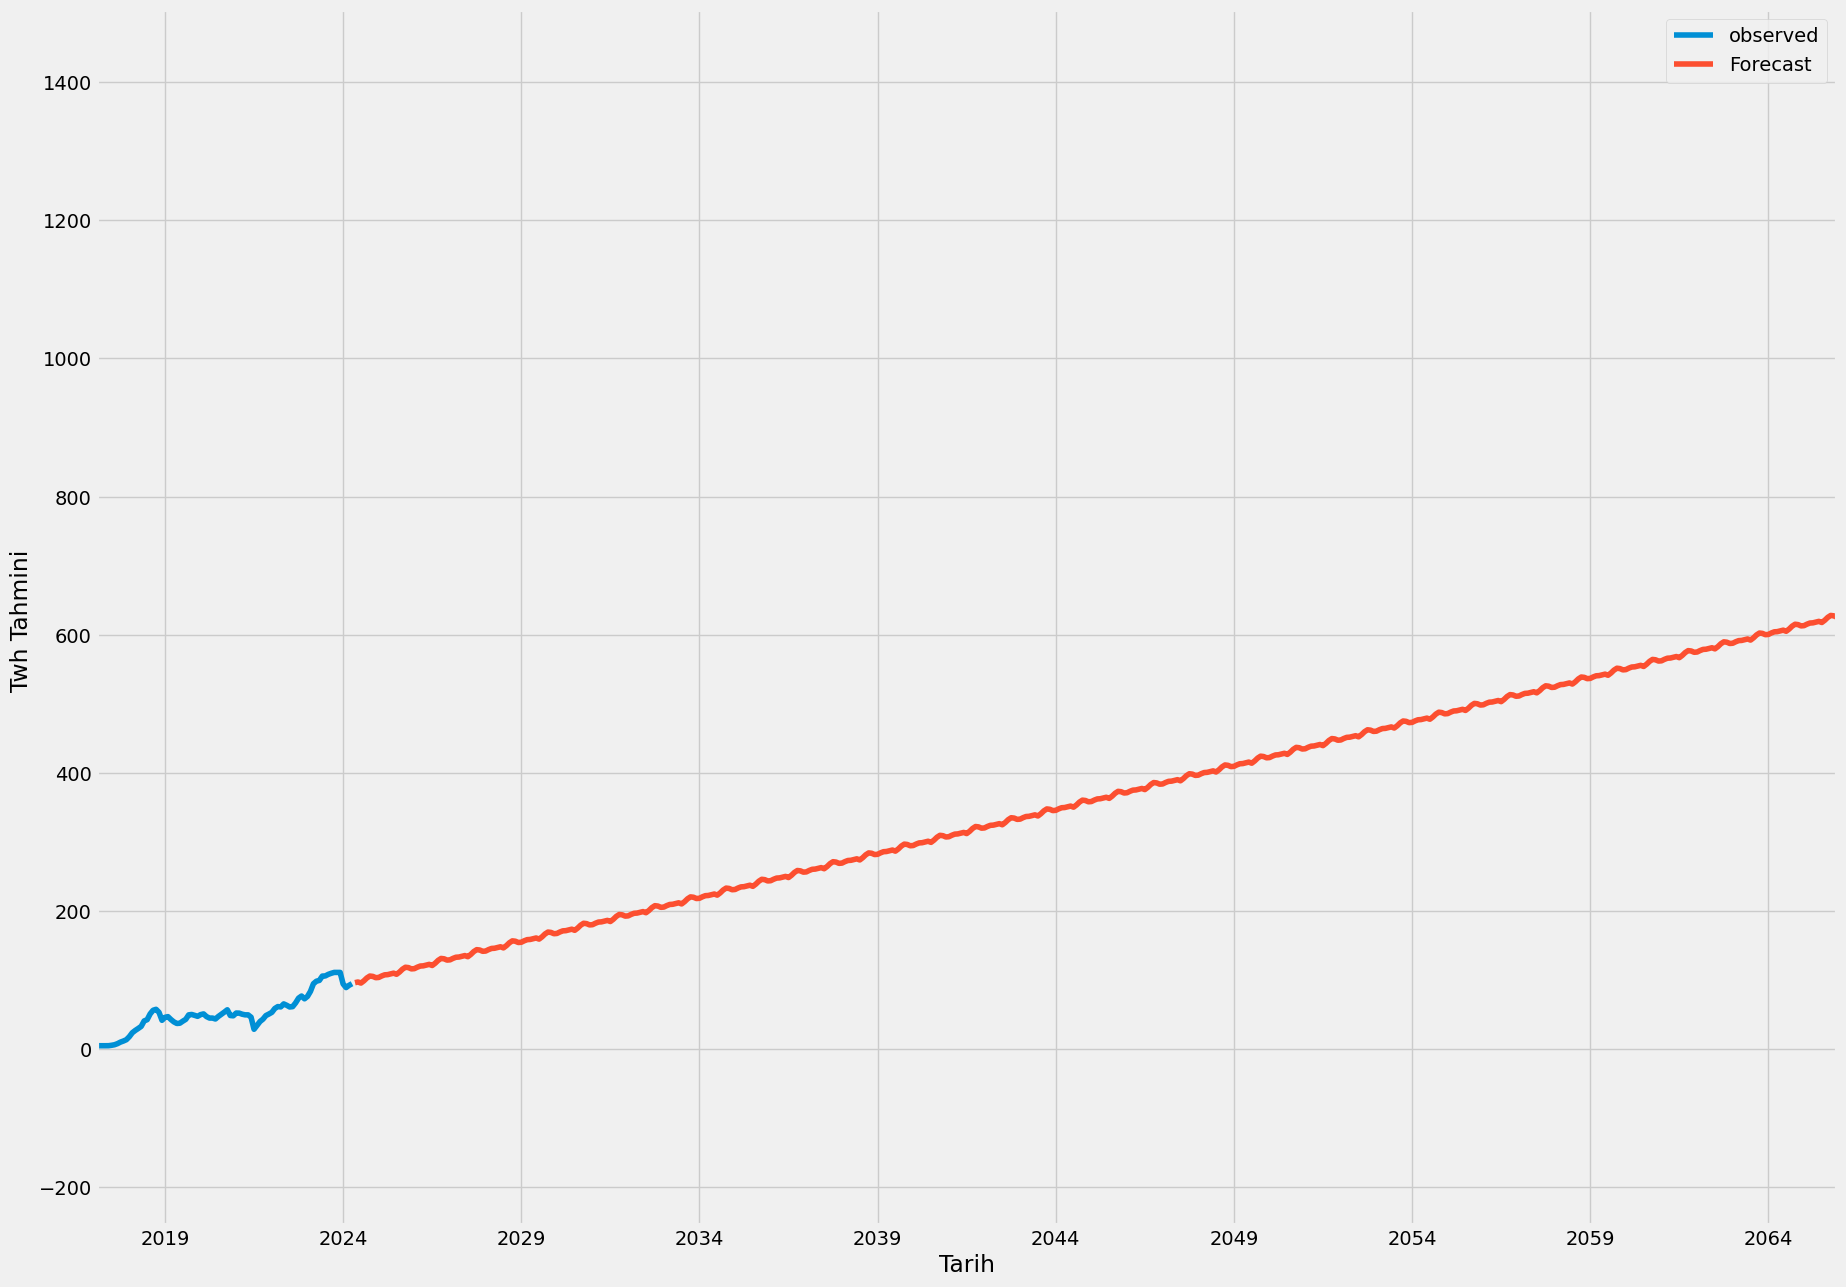

In [137]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()
ax = minTwhPerYear_monthly_mean.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=0.00)
ax.set_xlabel('Tarih')
ax.set_ylabel('Twh Tahmini ')

plt.legend()
plt.show()

In [85]:
y

,minTwhPerYear
date,
2017-02-16,5.131475
2017-02-17,5.131475
2017-02-18,5.131475
2017-02-19,5.131475
2017-02-20,5.131475
...,...
2024-04-12,95.225896
2024-04-13,95.880830
2024-04-14,96.487875


In [95]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(minTwhPerYear_monthly_mean_forecasted)
print(f'p-value: {adf_test[1]}')

p-value: 0.22959249631092743


<Axes: xlabel='date'>

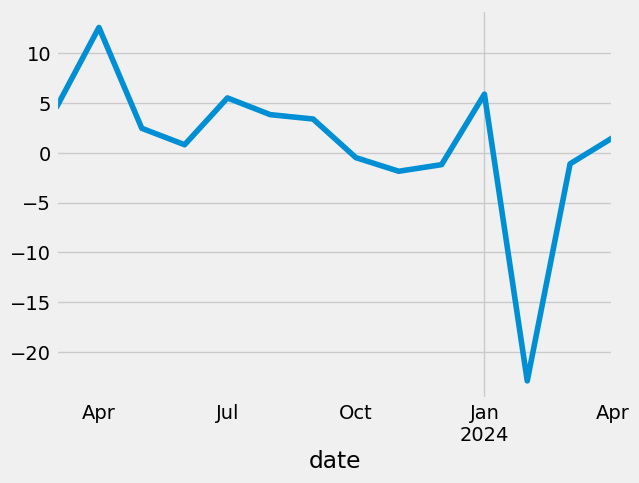

In [99]:
df_train_diff = minTwhPerYear_monthly_mean_forecasted.diff().dropna()
df_train_diff.plot()

In [ ]:
R-kare değeri: 0.44562811313091577
'R-kare (R-squared), '

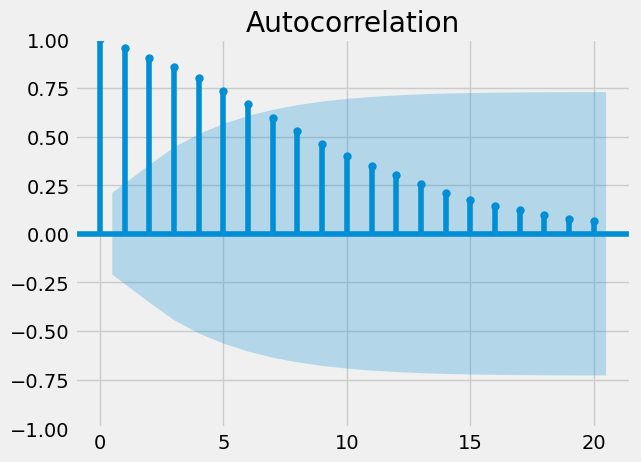

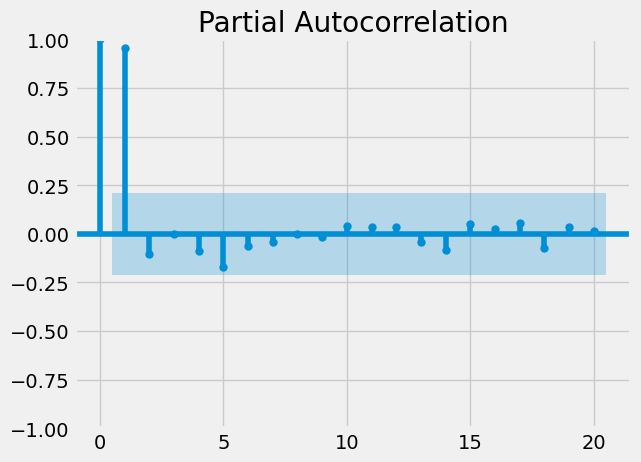

In [109]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(minTwhPerYear_monthly_mean)

pacf_original = plot_pacf(minTwhPerYear_monthly_mean)

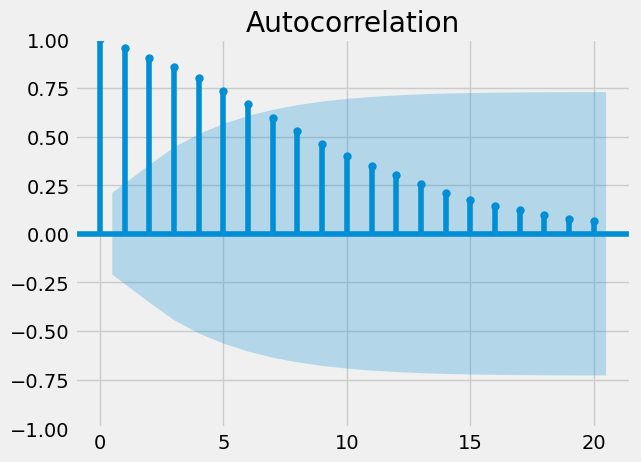

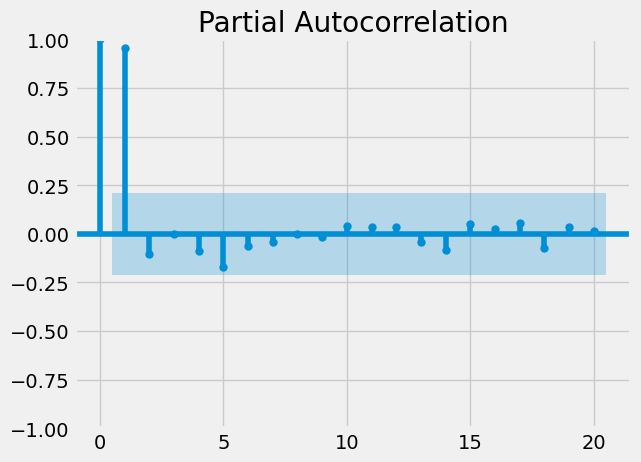

In [110]:
acf_diff = plot_acf(minTwhPerYear_monthly_mean)

pacf_diff = plot_pacf(minTwhPerYear_monthly_mean)